# Facial Keyponts Detection

https://www.kaggle.com/c/facial-keypoints-detection

In [1]:
%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from random import randrange

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms

import sys
sys.path.append('../')
from pycoach.coach.coach import Coach
from pycoach.datasets.facialkeypoints import *

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: True


## Cria DataLoader para plot dos exemplos

In [3]:
train_file = 'data/training.csv'

In [4]:
facial_dataset = FacialKeypointsDataset(train_file, train=True, 
                                       transform=transforms.Compose([
                                           Normalize(),
                                           Channel(),
                                           #ToTensor(),
                                       ]))

## Plotando alguns exemplos

<IPython.core.display.Javascript object>


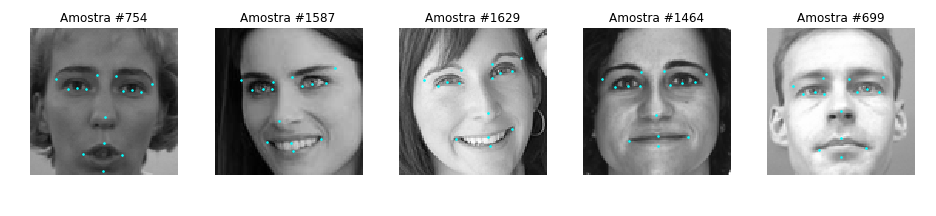

In [5]:
fig = plt.figure(figsize=(13,3))

for i in range(5):
    img = randrange(0, len(facial_dataset))
    sample = facial_dataset[img]

    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('Amostra #{}'.format(img))
    ax.axis('off')
    plot_image(sample['image'], sample['keypoints'])

plt.show()

In [6]:
del facial_dataset

## Cria DataLoader para treinamento e validação

In [7]:
facial_dataset_train = FacialKeypointsDataset(train_file, train=True, 
                                       transform=transforms.Compose([
                                           Normalize(),
                                           Channel(),
                                           ToTensor(),
                                       ]))

facial_dataset_validate = FacialKeypointsDataset(train_file, train=False,
                                       transform=transforms.Compose([
                                           Normalize(),
                                           Channel(),
                                           ToTensor(),
                                       ]))

In [8]:
train_loader = torch.utils.data.DataLoader(facial_dataset_train,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=1)

validate_loader = torch.utils.data.DataLoader(facial_dataset_validate,
                                          batch_size=64,
                                          shuffle=False,
                                          num_workers=1)

## Construindo o modelo

In [9]:
class MyDense(torch.nn.Module):
    def __init__(self):
        super(MyDense, self).__init__()
        
        self.dense1 = torch.nn.Linear(512 * 3 * 3, 1024)
        self.drop1 = torch.nn.Dropout(0.5)
        self.dense2 = torch.nn.Linear(1024, 512)
        self.drop2 = torch.nn.Dropout(0.5)
        self.dense3 = torch.nn.Linear(512, 30)
        
    def forward(self, x):
        x = x.view(-1, 512 * 3 * 3)
        x = F.relu(self.dense1(x))
        x = self.drop1(x)
        x = self.dense2(x)
        x = self.drop2(x)
        x = self.dense3(x)
        return x
    
class Net(torch.nn.Module):
    def __init__(self, model_vgg):
        super(Net, self).__init__()
        
        self.vgg = model_vgg
        self.dense = MyDense()
        
    def forward(self, x):
        x = self.vgg(x)
        x = self.dense(x)
        return x

In [10]:
model_vgg = models.vgg11(pretrained=True)
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier = MyDense()

if use_gpu:
    model_vgg.cuda()

print(model_vgg)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU (inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU (inplace)
    (15): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU (inpla

## Extraindo características

In [11]:
def feature_extractor(loader, model):
    if use_gpu:
        features = torch.Tensor().cuda()
        feature_labels = torch.Tensor().cuda()
    else:
        features = torch.Tensor()
        feature_labels = torch.Tensor()
    for batches, data in enumerate(loader):
        if isinstance(data, dict):
            inputs, labels = data.values()
        else:
            inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                    Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        features = torch.cat((features, model(inputs).data))
        feature_labels = torch.cat((feature_labels, labels.data))
    return (features, feature_labels)

In [12]:
features_train, labels_train = feature_extractor(train_loader, model_vgg.features)
features_validate, labels_validate = feature_extractor(validate_loader, model_vgg.features)

In [13]:
features_train_dataset = torch.utils.data.TensorDataset(features_train.cpu(), labels_train.cpu())
features_validate_dataset = torch.utils.data.TensorDataset(features_validate.cpu(), labels_validate.cpu())

## DataLoaders das features

In [14]:
features_train_loader = torch.utils.data.DataLoader(features_train_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=1)

features_validate_loader = torch.utils.data.DataLoader(features_validate_dataset,
                                          batch_size=64,
                                          shuffle=False,
                                          num_workers=1)

## Compilando e treinando

In [15]:
from pycoach.coach.callbacks import Plotter

In [16]:
loaders = {'train': features_train_loader, 'validate': features_validate_loader}
optimizer = torch.optim.Adam(model_vgg.classifier.parameters())
loss_fn = torch.nn.MSELoss()
epochs = 50

# callbacks
plotter = Plotter()

In [17]:
coach = Coach(model_vgg.classifier, loaders, optimizer, loss_fn)

<IPython.core.display.Javascript object>


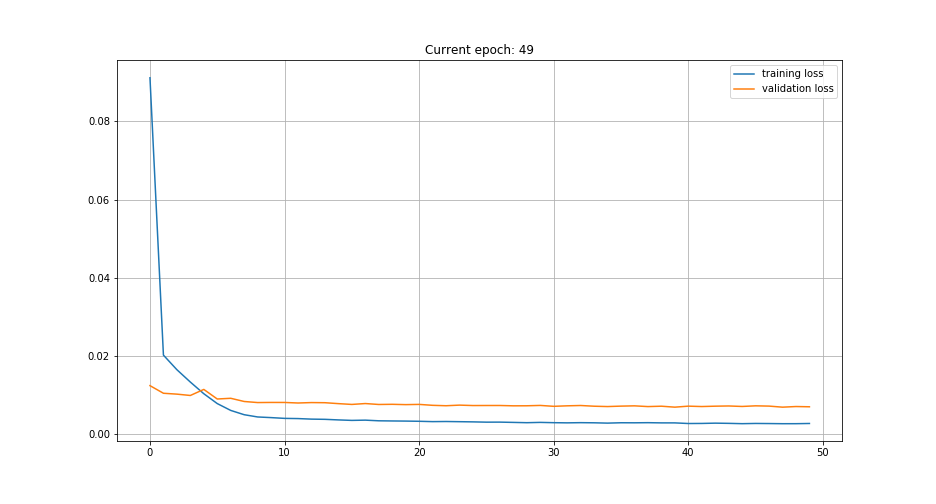

In [18]:
coach.train(epochs, verbose=0, callbacks=[plotter])

## Salva modelo

In [19]:
coach.save('./net.pytorch')

## Avaliando a rede no conjunto de validação

In [ ]:
coach.load('./net.pytorch')

In [20]:
coach.model = model_vgg

In [21]:
y_predicted = coach.predict(validate_loader)

In [22]:
if use_gpu:
    y_predicted = y_predicted.cpu()

## Visualizando algumas previsões

<IPython.core.display.Javascript object>


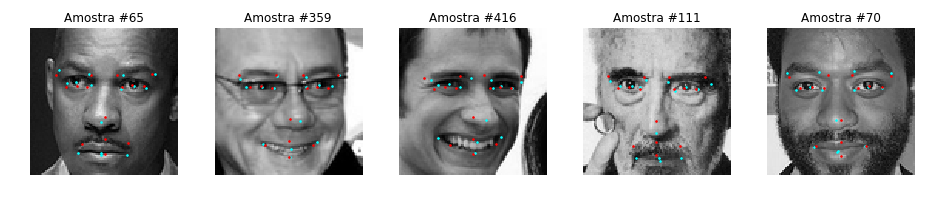

In [23]:
fig = plt.figure(figsize=(13,3))

for i in range(5):
    img = randrange(0, len(facial_dataset_validate))
    sample = facial_dataset_validate[img]

    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('Amostra #{}'.format(img))
    ax.axis('off')
    plot_image(sample['image'].numpy().transpose(1,2,0), sample['keypoints'].numpy(), y_predicted[img].numpy())

plt.show()